In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import json
from pathlib import Path
import torch

from cupbearer import data, detectors, models, scripts, tasks, utils, analysis
from torch.utils.data import DataLoader

# Training a backdoored classifier
First, we train a classifier on poisoned data:

In [13]:
train_data = data.MNIST()
val_data = data.MNIST(train=False)

In [14]:
model = models.MLP(input_shape=(28, 28), hidden_dims=[128, 128], output_dim=10)

In [15]:
class SubtleBackdoorClassifier(scripts._shared.Classifier):
    def __init__(
        self,
        names: list[str],
        model: torch.nn.Module,
        lr: float,
        num_classes: int | None = None,
        num_labels: int | None = None,
        val_loader_names: list[str] | None = None,
        test_loader_names: list[str] | None = None,
        save_hparams: bool = True,
        task: scripts._shared.ClassificationTask = "multiclass",
        activation_loss_weight: float = 1.0,
    ):
        super().__init__(
            model=model,
            lr=lr,
            num_classes=num_classes,
            num_labels=num_labels,
            val_loader_names=val_loader_names,
            test_loader_names=test_loader_names,
            save_hparams=save_hparams,
            task=task,
        )

        self.names = names
        self.activation_loss_weight = activation_loss_weight

    def training_step(self, batch, batch_idx):
        (x, y), is_backdoored = batch
        activations, logits = utils.get_activations(
            self.model, self.names, x, return_output=True, no_grad=False
        )
        task_loss = self.loss_func(logits, y)

        activation_loss = 0
        for name, acts in activations.items():
            assert acts.ndim == 2
            distances = torch.norm(acts[None] - acts[:, None], dim=-1)
            total_mean_dist = distances.sum()
            cross_mean_dist = distances[
                ~is_backdoored[None] * is_backdoored[:, None]
            ].sum()
            activation_loss += cross_mean_dist / total_mean_dist

        self.log("train/activation_loss", activation_loss)

        loss = task_loss + self.activation_loss_weight * activation_loss

        self.log("train/loss", loss, prog_bar=True)
        self.train_accuracy(logits, y)
        self.log("train/acc_step", self.train_accuracy)
        return loss

In [25]:
scripts.train_classifier(
    path=(classifier_path := utils.log_path("logs/demo/classifier")),
    model=model,
    train_loader=DataLoader(
        data.BackdoorDataset(
            original=train_data,
            backdoor=data.CornerPixelBackdoor(
                p_backdoor=0.20, return_anomaly_label=True
            ),
        ),
        batch_size=256,
        shuffle=True,
    ),
    num_classes=10,
    val_loaders={
        "clean": DataLoader(val_data, batch_size=1024, shuffle=False),
        "backdoor": DataLoader(
            data.BackdoorDataset(
                # By default, the poison rate is 100%, so this will let us evaluate
                # performance on completely poisoned data
                original=val_data,
                backdoor=data.CornerPixelBackdoor(),
            ),
            batch_size=1024,
            shuffle=False,
        ),
    },
    make_classifier_fn=lambda *args, **kwargs: SubtleBackdoorClassifier(
        names=[
            "layers.linear_0.output",
            "layers.linear_1.output",
            "layers.linear_2.output",
        ],
        activation_loss_weight=10.0,
        *args,
        **kwargs,
    ),
    max_epochs=5,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 118 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | ModuleList         | 0     
3 | test_accuracy  | ModuleList         | 0     
------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


{'train/activation_loss': tensor(0.4410),
 'train/loss': tensor(4.6348),
 'train/acc_step': tensor(0.9271),
 'clean/loss/dataloader_idx_0': tensor(0.1920),
 'clean/acc_step/dataloader_idx_0': tensor(0.9431),
 'backdoor/loss/dataloader_idx_1': tensor(0.0564),
 'backdoor/acc_step/dataloader_idx_1': tensor(0.9979),
 'clean/acc_epoch': tensor(0.9431),
 'backdoor/acc_epoch': tensor(0.9979),
 'train/acc_epoch': tensor(0.9547)}

We can also explicitly evaluate the trained model (right now this is pretty limited and doesn't support multiple datasets at once). In this case it doesn't tell us anything new, but it can be useful if we want to evaluate a model on additional data later:

In [26]:
scripts.eval_classifier(
    data=val_data,
    model=model,
    path=classifier_path,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/acc_epoch       │    0.9430999755859375     │
│       test/acc_step       │    0.9430999755859375     │
│         test/loss         │    0.19203969836235046    │
└───────────────────────────┴───────────────────────────┘

These results will also have been stored to `<log path>/eval.json` if we want to process them further (e.g. to compare many runs):

In [ ]:
with open(classifier_path / "eval.json") as f:
    print(json.load(f))

# Analysis

In [27]:
task = tasks.backdoor_detection(model, train_data, val_data, data.CornerPixelBackdoor())

In [28]:
names = ["layers.linear_0.output", "layers.linear_1.output", "layers.linear_2.output"]
task_data = analysis.TaskData.from_task(
    task,
    names,
    n_samples=256,
)

100%|██████████| 10/10 [00:00<00:00, 26.38it/s]


/Users/erik/code/cupbearer/src/cupbearer/analysis/variances.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.collector.activation_names, rotation=45, ha="right")


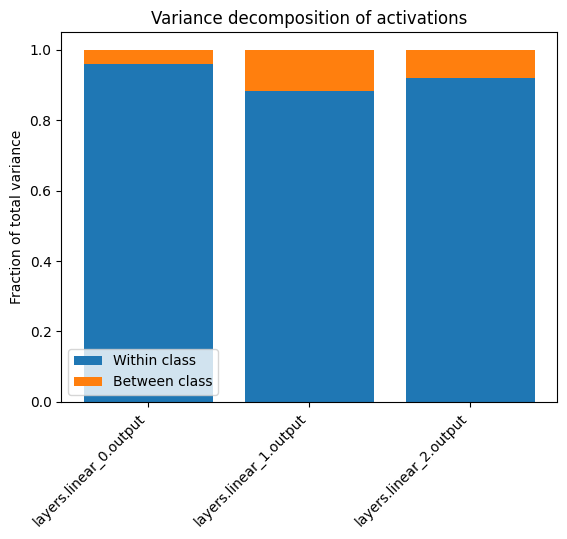

In [29]:
fig = analysis.plot_variances(task_data)

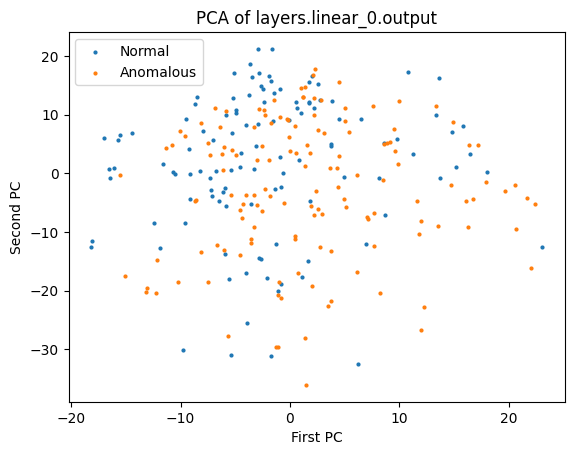

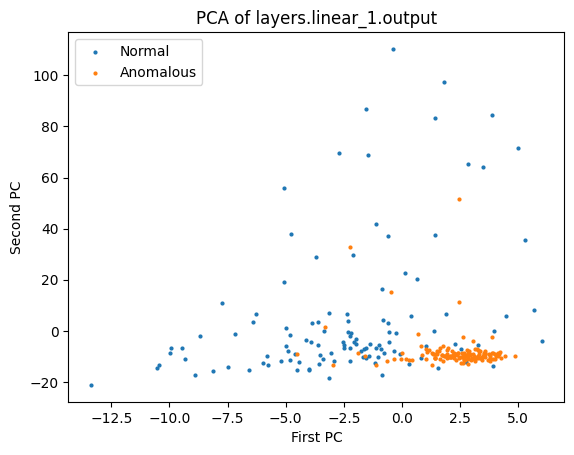

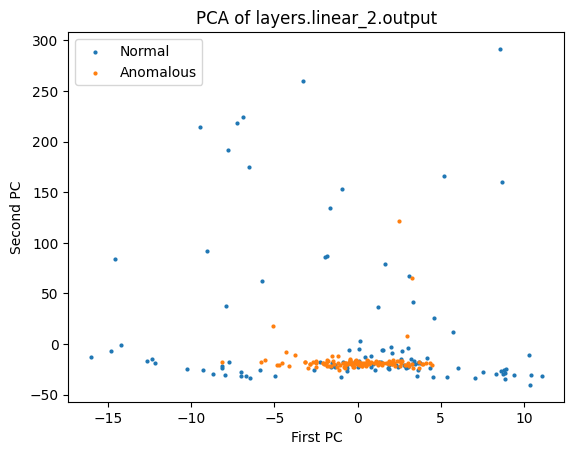

In [30]:
for idx in range(len(names)):
    try:
        fig = analysis.plot_pca(task_data, names[idx], title=f"PCA of {names[idx]}")
    except:
        print(f"Failed to plot PCA for {names[idx]}")

# Training a backdoor detector
We'll train a very simple detector using the Mahalanobis distance. Our model is still in memory, but just for demonstration let's load it again:

In [5]:
# Initialize a new model with the same architecture as before:
model = models.MLP(input_shape=(28, 28), hidden_dims=[128, 128], output_dim=10)
# Load the weights:
classifier_path = Path("logs/demo/classifier/2024-06-27_16-27-55")
models.load(model, classifier_path)

In [10]:
model

MLP(
  (layers): ModuleDict(
    (linear_0): Linear(in_features=784, out_features=128, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=128, out_features=10, bias=True)
  )
)

2024-06-27 16:47:19.198 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
layers.linear_0.output: torch.Size([128])
layers.linear_1.output: torch.Size([128])
layers.linear_2.output: torch.Size([10])
100%|██████████| 59/59 [00:06<00:00,  9.52it/s]
2024-06-27 16:47:25.398 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to logs/demo/detector/2024-06-27_16-47-19/detector


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

2024-06-27 16:47:25.810 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 1.0000
2024-06-27 16:47:25.811 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 1.0000


(defaultdict(dict, {'all': {'AUC_ROC': 1.0, 'AP': 1.0}}),
 {'all': <Figure size 640x480 with 1 Axes>})

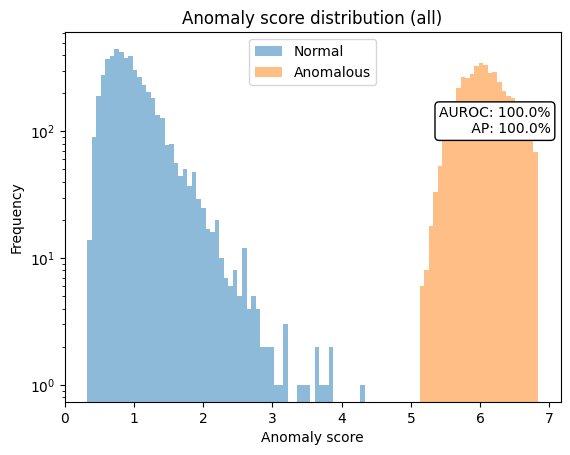

In [31]:
scripts.train_detector(
    save_path=(detector_path := utils.log_path("logs/demo/detector")),
    task=task,
    detector=detectors.MahalanobisDetector(
        activation_names=[
            "layers.linear_0.output",
            "layers.linear_1.output",
            "layers.linear_2.output",
        ]
    ),
    num_classes=10,
)

As we can see, this was a trivial detection task. As an ablation, we can test whether the detector specifically flags backdoored inputs as anomalous, or just anything out of distribution. Let's again reload the detector just to show how that works:

In [32]:
detector = detectors.MahalanobisDetector(
    activation_names=[
        "layers.linear_0.output",
        "layers.linear_1.output",
        "layers.linear_2.output",
    ]
)
# TODO: The fact that weights are saved in "detector" is just a convention used by
# the train_detector script, this is kind of weird.
detector.load_weights(detector_path / "detector")

2024-06-27 16:47:32.323 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:261 - Loading detector from logs/demo/detector/2024-06-27_16-47-19/detector


2024-06-27 16:47:34.754 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (layers.linear_0.output): 1.0000
2024-06-27 16:47:34.755 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (layers.linear_0.output): 1.0000
2024-06-27 16:47:34.814 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (layers.linear_1.output): 0.6048
2024-06-27 16:47:34.815 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (layers.linear_1.output): 0.5781
2024-06-27 16:47:35.026 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (layers.linear_2.output): 0.4693
2024-06-27 16:47:35.027 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (layers.linear_2.output): 0.4596


(defaultdict(dict,
             {'layers.linear_0.output': {'AUC_ROC': 1.0, 'AP': 1.0},
              'layers.linear_1.output': {'AUC_ROC': 0.60483254,
               'AP': 0.578113913499437},
              'layers.linear_2.output': {'AUC_ROC': 0.46929152,
               'AP': 0.4596099555595818}}),
 {'layers.linear_0.output': <Figure size 640x480 with 1 Axes>,
  'layers.linear_1.output': <Figure size 640x480 with 1 Axes>,
  'layers.linear_2.output': <Figure size 640x480 with 1 Axes>})

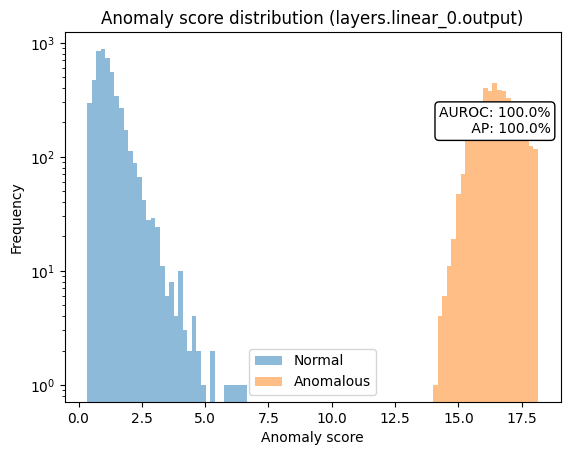

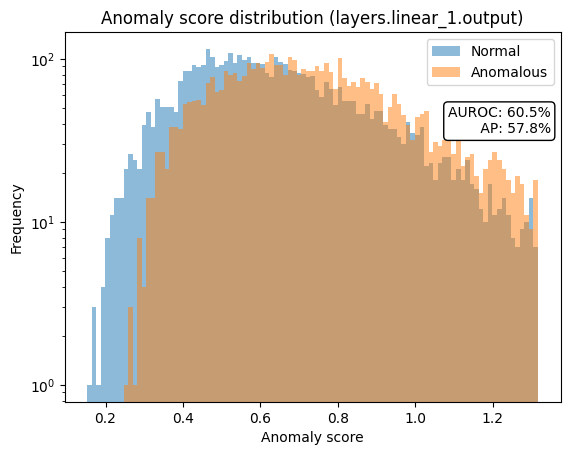

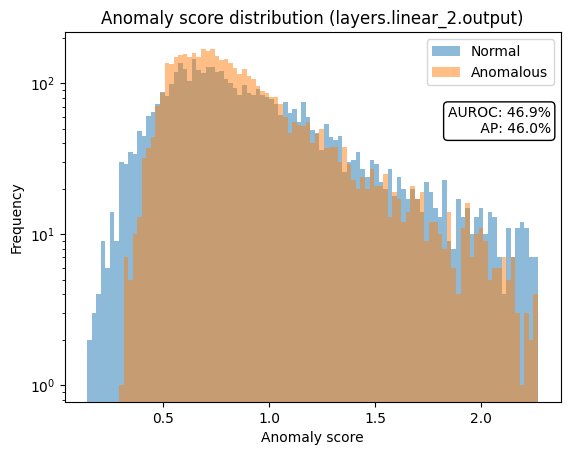

In [33]:
detector.set_model(model)
detector.eval(task.test_data, layerwise=True)